# Exploratory Data Analysis

In [1]:
# load and view a .npy file
import numpy as np
from matplotlib import pyplot as plt
import sys
# load the .npy file
initial_inputs = np.load("initial_inputs.npy")
initial_outputs = np.load("initial_outputs.npy")
# summarize shape
print(initial_inputs.shape)
print(initial_outputs.shape)

# create a dataframe from inputs and outputs
import pandas as pd
data = pd.DataFrame(initial_inputs, columns=[f'input_{i}' for i in range(initial_inputs.shape[1])])
data['output'] = initial_outputs
print(data.head())

(20, 5)
(20,)
    input_0   input_1   input_2   input_3   input_4    output
0  0.728186  0.154693  0.732552  0.693997  0.056401 -0.714265
1  0.242384  0.844100  0.577809  0.679021  0.501953 -1.209955
2  0.729523  0.748106  0.679775  0.356552  0.671054 -1.672200
3  0.770620  0.114404  0.046780  0.648324  0.273549 -1.536058
4  0.618812  0.331802  0.187288  0.756238  0.328835 -0.829237


## Observations


# Gaussian Process with EI, PI and UCB

Next sample based on UCB: [0.35353535 0.5        0.5        0.5        0.5       ]
Next sample based on EI: [0.34343434 0.5        0.5        0.5        0.5       ]
Next sample based on PI: [0.35353535 0.5        0.5        0.5        0.5       ]


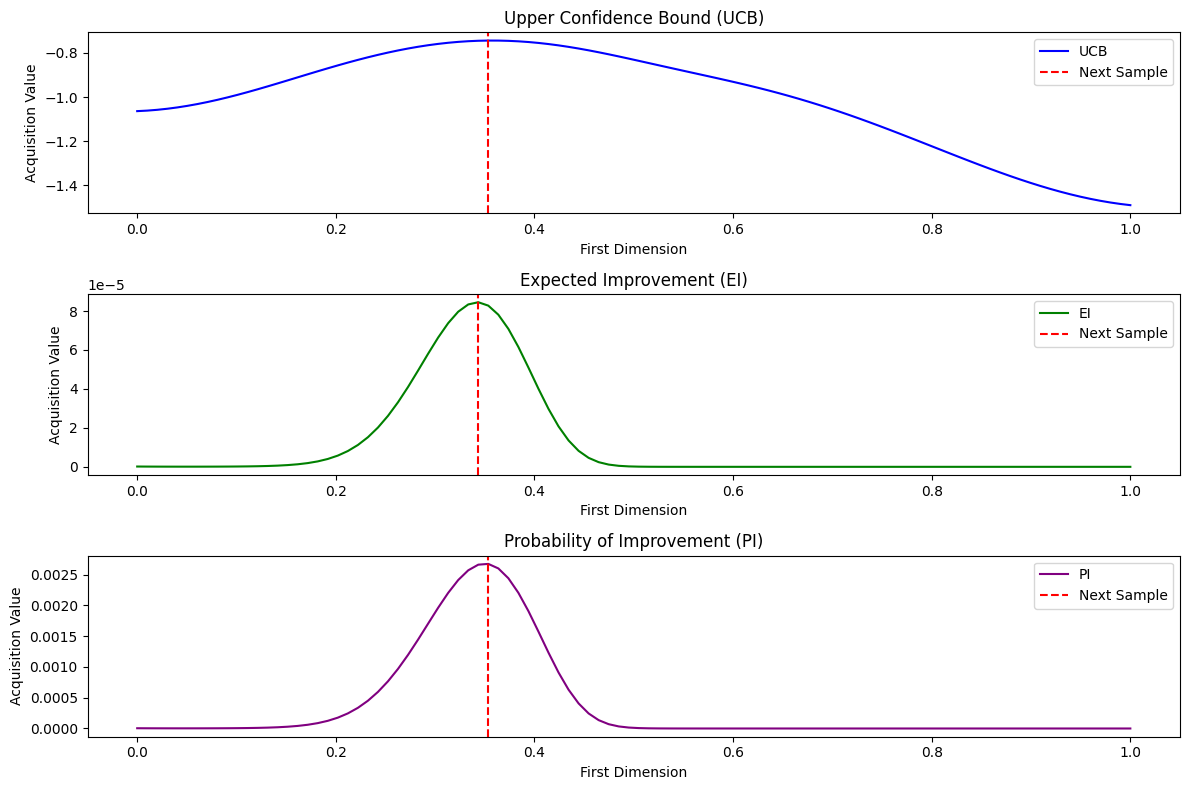

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm

def fit_gp(X, y):
    """
    Fit a Gaussian Process with ARD RBF kernel on 4D inputs.
    Assumes X is scaled to [0,1]^4 (recommended).
    """
    kernel = C(1.0, (1e-3, 1e3)) * RBF(
        length_scale=[0.3, 0.3, 0.3, 0.3, 0.3],
        length_scale_bounds=(1e-2, 1e2)
    )
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=1e-4,          # small noise term; tune for your data
        normalize_y=True
    )
    gp.fit(X, y)
    return gp

# Load the dataset
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

gp = fit_gp(X, y)

# Generate candidate points for visualization (fix 4 dimensions, vary 1 dimension)
n_candidates = 100
X_candidates = np.zeros((n_candidates, 5))
X_candidates[:, 0] = np.linspace(0, 1, n_candidates)  # vary first dimension
X_candidates[:, 1:] = 0.5  # fix others at 0.5

# Predict mean and standard deviation for candidates
mu, sigma = gp.predict(X_candidates, return_std=True)

# Best observed value
y_best = np.max(y)

# Acquisition functions
def UCB(mu, sigma, kappa=2.5):
    return mu + kappa * sigma

def EI(mu, sigma, y_best):
    improvement = mu - y_best
    Z = improvement / sigma
    return (improvement * norm.cdf(Z) + sigma * norm.pdf(Z))

def PI(mu, sigma, y_best):
    Z = (mu - y_best) / sigma
    return norm.cdf(Z)

ucb_values = UCB(mu, sigma)
ei_values = EI(mu, sigma, y_best)
pi_values = PI(mu, sigma, y_best)

# Select next sample for each acquisition function
next_ucb = X_candidates[np.argmax(ucb_values)]
next_ei = X_candidates[np.argmax(ei_values)]
next_pi = X_candidates[np.argmax(pi_values)]

print("Next sample based on UCB:", next_ucb)
print("Next sample based on EI:", next_ei)
print("Next sample based on PI:", next_pi)

# Visualization of acquisition functions
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(X_candidates[:, 0], ucb_values, label='UCB', color='blue')
plt.title('Upper Confidence Bound (UCB)')
plt.xlabel('First Dimension')
plt.ylabel('Acquisition Value')
plt.axvline(next_ucb[0], color='red', linestyle='--', label='Next Sample')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(X_candidates[:, 0], ei_values, label='EI', color='green')
plt.title('Expected Improvement (EI)')
plt.xlabel('First Dimension')
plt.ylabel('Acquisition Value')
plt.axvline(next_ei[0], color='red', linestyle='--', label='Next Sample')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(X_candidates[:, 0], pi_values, label='PI', color='purple')
plt.title('Probability of Improvement (PI)')
plt.xlabel('First Dimension')
plt.ylabel('Acquisition Value')
plt.axvline(next_pi[0], color='red', linestyle='--', label='Next Sample')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
random_numbers = [np.random.random() for _ in range(6)]
print(random_numbers)

[0.5077287964287477, 0.3826373790755797, 0.45499390164636544, 0.37412641399109225, 0.825804128246081, 0.9273054767462718]


# Week 1 Submission
0.507728-0.382637-0.454993-0.374126-0.825804